In [1]:
import os
from dotenv import load_dotenv

# from datetime import datetime, timedelta
import pandas as pd
# import matplotlib.pyplot as plt

# from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import numpy as np
# from functions import util

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


/opt/anaconda3/envs/crypto-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
os.environ["HOPSWORKS_API_KEY"] = os.getenv("HOPSWORKS_API_KEY")
project = hopsworks.login()

fs = project.get_feature_store() 

2024-12-28 03:28:43,900 INFO: Initializing external client
2024-12-28 03:28:43,900 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-28 03:28:45,450 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164448


In [3]:
solana_feature_group = fs.get_feature_group(
    name="solana",  
    version=1
)

# Step 3: Read the data from the feature group
solana_df = solana_feature_group.read().sort_values(by='timestamp', inplace=False).reset_index(drop=True)
# solana_df['open_diff'] = solana_df['open'].diff().fillna(0)
solana_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.78s) 


,timestamp,open,high,low,close,volume,volume_buy,volume_sell
0,1623888000,40.23,40.57,38.30,39.13,6007.618490,2885.660324,3121.958166
1,1623974400,39.13,39.36,35.00,36.62,13557.357196,7925.472309,5631.884887
2,1624060800,36.62,37.35,35.00,35.45,16986.163716,9258.361133,7727.802583
3,1624147200,35.45,35.89,31.48,35.28,38681.265775,21052.579774,17628.686001
4,1624233600,35.28,35.28,26.00,26.55,41903.613224,15380.745579,26522.867646
...,...,...,...,...,...,...,...,...
1281,1734566400,206.49,215.00,186.80,193.65,452547.729871,185623.785796,266923.944075
1282,1734652800,193.65,199.44,175.01,194.40,463451.482080,210245.812667,253205.669413
1283,1734739200,194.40,201.91,178.50,181.06,308103.063575,122417.224892,185685.838684
1284,1734825600,181.06,187.86,176.87,180.34,218352.282441,108511.764430,109840.518011


In [4]:
solana_df = solana_df[["timestamp","open"]]
solana_df

,timestamp,open
0,1623888000,40.23
1,1623974400,39.13
2,1624060800,36.62
3,1624147200,35.45
4,1624233600,35.28
...,...,...
1281,1734566400,206.49
1282,1734652800,193.65
1283,1734739200,194.40
1284,1734825600,181.06


In [5]:
# Step 2: Retrieve the feature group by name and version
bitcoin_feature_group = fs.get_feature_group(
    name="bitcoin",  
    version=1
)

# Step 3: Read the data from the feature group
bitcoin_df = bitcoin_feature_group.read().sort_values(by='timestamp', inplace=False).reset_index(drop=True)
# bitcoin_df['open_diff'] = bitcoin_df['open'].diff()
bitcoin_df = bitcoin_df[["timestamp","open"]]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 


In [6]:
fs = project.get_feature_store(name='kth_lab1_2024_featurestore')
fng_feature_group = fs.get_feature_group('f_n_g_index', version=6)
fng_df = fng_feature_group.read()
fng_df['timestamp'] = fng_df['date'].astype('int64')/ 10**6 # Convert nanoseconds to seconds
fng_df = fng_df.sort_values(by='timestamp', inplace=False).reset_index(drop=True)
fng_df.drop(columns=["date"], inplace=True)
fng_labels_to_numbers_map={"Extreme Fear":0, "Fear":1, "Neutral":2, "Greed":3, "Extreme Greed":4} 
fng_numbers_to_labels_map={0:"Extreme Fear", 1:"Fear", 2:"Neutral", 3:"Greed", 4:"Extreme Greed"} 

fng_df['fng_classification'] = fng_df['fng_classification'].replace(fng_labels_to_numbers_map)
fng_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 


,fng_value,fng_classification,timestamp
0,30,1,1.517443e+09
1,15,0,1.517530e+09
2,40,1,1.517616e+09
3,24,0,1.517702e+09
4,11,0,1.517789e+09
...,...,...,...
2509,75,3,1.734566e+09
2510,74,3,1.734653e+09
2511,73,3,1.734739e+09
2512,73,3,1.734826e+09


In [7]:

all_data = pd.merge(solana_df, bitcoin_df, how='inner', on="timestamp",suffixes=('_solana', '_bitcoin'))  
all_data = pd.merge(all_data, fng_df, how='inner', on="timestamp")

# target = all_data["open_solana"]
# all_data = all_data.drop(["open_solana"], axis=1, inplace=False)
all_data


,timestamp,open_solana,open_bitcoin,fng_value,fng_classification
0,1623888000,40.23,38337.1,26,1
1,1623974400,39.13,38078.2,25,0
2,1624060800,36.62,35824.0,23,0
3,1624147200,35.45,35490.5,21,0
4,1624233600,35.28,35595.0,23,0
...,...,...,...,...,...
1280,1734566400,206.49,100166.1,75,3
1281,1734652800,193.65,97431.4,74,3
1282,1734739200,194.40,97781.8,73,3
1283,1734825600,181.06,97232.6,73,3


In [8]:
if "timestamp" in all_data.columns:
    all_data = all_data.drop(columns=['timestamp'])

# Move 'open_solana' at the end
columns = [col for col in all_data.columns if col != 'open_solana'] 
columns.append('open_solana')  
all_data = all_data[columns] 
all_data_values = all_data.values


# X = all_data.drop(columns=['open_solana'])  # All features except the target
# y = all_data['open_solana'] 
all_data

,open_bitcoin,fng_value,fng_classification,open_solana
0,38337.1,26,1,40.23
1,38078.2,25,0,39.13
2,35824.0,23,0,36.62
3,35490.5,21,0,35.45
4,35595.0,23,0,35.28
...,...,...,...,...
1280,100166.1,75,3,206.49
1281,97431.4,74,3,193.65
1282,97781.8,73,3,194.40
1283,97232.6,73,3,181.06


In [9]:
def create_featured_label(data, time_steps, num_predictions):
    """
        Creates an extra label that has the percentage change of the next num_predictions days.
    """
    percentage_change_label = []
    
    for i in range(len(data) - time_steps-num_predictions):
        first_label_row_index = i+time_steps
        labels = data[first_label_row_index:first_label_row_index+num_predictions, -1]
        first_price = labels[0]
        labels = 100*(labels - first_price) / first_price
        labels = [round(l,2) for l in labels]
        percentage_change_label.append(labels)
    return np.array(percentage_change_label)


def create_sequences(data, time_steps, num_predictions):
    X, y = [], []
    for i in range(len(data) - (time_steps+num_predictions)):
        first_label_row_index = i+time_steps
        row = data[i:first_label_row_index, :-1]
        
        X.append(row) 
        labels = data[first_label_row_index:first_label_row_index+num_predictions, -1]
        labels = [round(l,2) for l in labels]
        y.append(labels)
    return np.array(X), np.array(y)

In [10]:
time_steps = 30
num_predictions = 30
X, y = create_sequences(all_data_values, time_steps=time_steps, num_predictions=num_predictions)
y_percentage_change = create_featured_label(all_data_values, time_steps=time_steps, num_predictions=num_predictions)


In [11]:
y_percentage_change

array([[  0.  ,   1.67,   2.02, ...,  55.99,  70.79,  68.01],
       [  0.  ,   0.34,  -8.27, ...,  67.98,  65.25, 100.  ],
       [  0.  ,  -8.58, -12.6 , ...,  64.69,  99.33, 131.73],
       ...,
       [  0.  ,   9.  ,   9.2 , ...,  -5.24, -12.34, -17.8 ],
       [  0.  ,   0.18,  -0.59, ..., -19.58, -24.59, -24.29],
       [  0.  ,  -0.77,  -1.68, ..., -24.72, -24.43, -29.62]])

In [12]:
def concatenate_labels(labels1, labels2):
    y = []
    for i in range(len(labels1)):
        y.append(np.concatenate((labels1[i],labels2[i])))
    return np.array(y)
y = concatenate_labels(y, y_percentage_change)

In [13]:
X.shape, y.shape

((1225, 30, 3), (1225, 60))

In [14]:
def train_val_test_split(X, labels, val_size=0.3, test_size=0.4):

    # Calculate split indices
    n_samples = X.shape[0]
    test_split_idx = int(n_samples * (1 - test_size))  
    val_split_idx = int(test_split_idx * (1 - val_size))  

    # Split X
    X_train = X[:val_split_idx] 
    X_val = X[val_split_idx:test_split_idx]  
    X_test = X[test_split_idx:]  #

    # labels
    labels_train = labels[:val_split_idx]
    labels_val = labels[val_split_idx:test_split_idx]
    labels_test = labels[test_split_idx:]


    return (X_train, X_val, X_test, labels_train, labels_val, labels_test)
(X_train, X_val, X_test, y_train, y_val, y_test ) = train_val_test_split(X, y)
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")
print(f"Labels1_train shape: {y_train.shape}, Labels1 val shape: {y_val.shape}, Labels1_test shape: {y_test.shape}")


X_train shape: (514, 30, 3), X_val shape: (221, 30, 3), X_test shape: (490, 30, 3)
Labels1_train shape: (514, 60), Labels1 val shape: (221, 60), Labels1_test shape: (490, 60)


In [15]:
scaler_features = MinMaxScaler(feature_range=(0, 1))

data_reshaped = X_train.reshape(-1, X_train.shape[2])  # Shape: (12680, 18)

data_scaled = scaler_features.fit_transform(data_reshaped)

X_train = data_scaled.reshape(X_train.shape)

# ************************************************

data_reshaped = X_val.reshape(-1, X_val.shape[2])  

data_scaled = scaler_features.transform(data_reshaped)

X_val = data_scaled.reshape(X_val.shape)

# *************************************************
data_reshaped = X_test.reshape(-1, X_test.shape[2]) 


data_scaled = scaler_features.transform(data_reshaped)

X_test = data_scaled.reshape(X_test.shape)



In [16]:
scaler_labels = MinMaxScaler(feature_range=(0, 1))
scaler_labels.fit(y_train)

y_train = scaler_labels.transform(y_train)
y_val = scaler_labels.transform(y_val)
y_test = scaler_labels.transform(y_test)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [18]:

model2 = Sequential()
model2.add(InputLayer((time_steps, X.shape[2])))
model2.add(LSTM(16, return_sequences=False))
model2.add(Dense(8, 'relu'))
model2.add(Dense(y.shape[1], 'linear'))
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │           540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,956 (7.64 KB)

 Trainable params: 1,956 (7.64 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
cp2 = ModelCheckpoint('model_30d_2/best_model.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [20]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape


((514, 30, 3), (514, 60), (221, 30, 3), (221, 60))

In [21]:

model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, callbacks=[cp2])

Epoch 1/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1543 - root_mean_squared_error: 0.3926 - val_loss: 0.0719 - val_root_mean_squared_error: 0.2682
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1584 - root_mean_squared_error: 0.3979 - val_loss: 0.0701 - val_root_mean_squared_error: 0.2647
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1456 - root_mean_squared_error: 0.3815 - val_loss: 0.0685 - val_root_mean_squared_error: 0.2617
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1526 - root_mean_squared_error: 0.3906 - val_loss: 0.0671 - val_root_mean_squared_error: 0.2590
Epoch 5/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1479 - root_mean_squared_error: 0.3846 - val_loss: 0.0660 - val_root_mean_squared_error: 0.2570
Epoch 6/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1430 - root_mean_squared_error: 0.3781 - val_loss: 0.0652 - val_root_mean_squared_error: 0.2553
Epoch 7/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss

In [22]:
train_predictions = model2.predict(X_train).flatten()
y_train_flattened = y_train.flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train_flattened})
train_results

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,Train Predictions,Actuals
0,0.158647,0.058619
1,0.155369,0.060401
2,0.148327,0.060766
3,0.134463,0.051448
4,0.160076,0.047073
...,...,...
30835,0.152167,0.156428
30836,0.169751,0.165024
30837,0.140021,0.141110
30838,0.143847,0.170045


In [23]:
# from tensorflow.keras.models import load_model

# model1 = load_model('model2/best_model.keras')


### Evaluate on test set

#### Train with validation set


In [24]:
model2.fit(X_val, y_val, validation_data=(X_train, y_train), epochs=100, callbacks=[cp2])

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0317 - root_mean_squared_error: 0.1780 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0994
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0209 - root_mean_squared_error: 0.1441 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0151 - root_mean_squared_error: 0.1226 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1219
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1251
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0119 - root_mean_squared_error: 0.1088 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1245
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0103 - root_mean_squared_error: 0.1013 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0098

In [25]:

test_predictions = model2.predict(X_test)


# test_predictions_unscaled =  scaler_labels.inverse_transform(test_predictions)
# y_test_unscaled = scaler_labels.inverse_transform(y_test)
# test_predictions_flattened = test_predictions_unscaled.flatten()
# y_test_flattened = y_test_unscaled.flatten()


test_predictions_flattened = test_predictions.flatten()
y_test_flattened = y_test.flatten()

test_results = pd.DataFrame(data={'Test Predictions':test_predictions_flattened, 'Actuals':y_test_flattened})

mse = mean_squared_error(y_test_flattened, test_predictions_flattened)
rmse = np.sqrt(mse)

res_dict = { 
        "MSE": str(mse),
        "R squared": str(rmse),
    }
# Print results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error (MSE): 0.01044332354692852
Root Mean Squared Error (RMSE): 0.10219258068435556


In [26]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions(y_predicted_sample, y_actual_sample, num_predictions):
  df = pd.DataFrame(data={'Predictions': y_predicted_sample, 'Actuals':y_actual_sample})
  plt.plot(df['Predictions'][0:num_predictions])
  plt.plot(df['Actuals'][0:num_predictions])
  plt.show()

  plt.plot(df['Predictions'][num_predictions:])
  plt.plot(df['Actuals'][num_predictions:])
  plt.show()
  return 

def predictions_table(y_predicted, y_actual, num_predictions):
  combined_array = np.column_stack((y_predicted, y_actual))
  
  results_price = pd.DataFrame(combined_array[:num_predictions], columns=['y_predicted_price','y_actual_price'])
  display(results_price)

  results_percentage = pd.DataFrame(combined_array[num_predictions:], columns=['y_predicted_percentage','y_actual_percentage'])
  display(results_percentage)


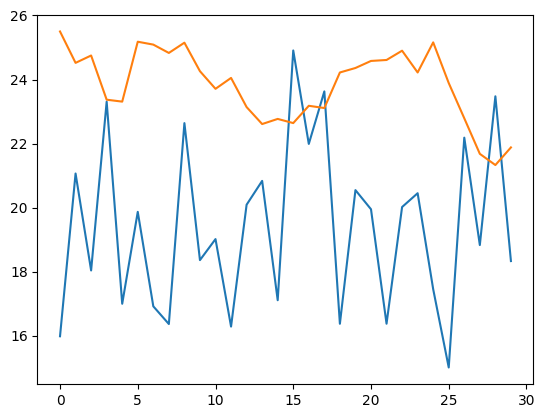

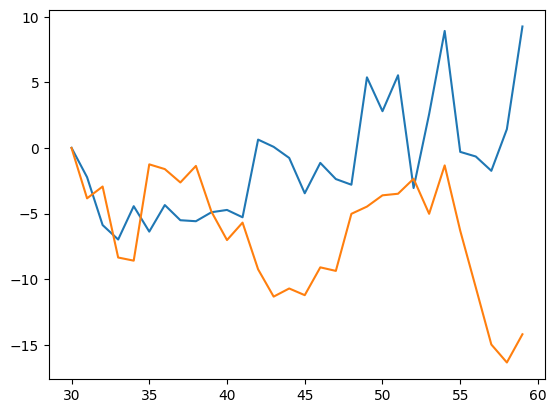

,y_predicted_price,y_actual_price
0,15.984347,25.50
1,21.065561,24.52
2,18.038939,24.75
3,23.309595,23.37
4,16.999214,23.31
5,19.868036,25.18
6,16.919117,25.09
7,16.366312,24.83
8,22.638851,25.15
9,18.362049,24.26


,y_predicted_percentage,y_actual_percentage
0,0.011296,0.00
1,-2.228954,-3.84
2,-5.876431,-2.94
3,-6.978671,-8.35
4,-4.438411,-8.59
5,-6.376692,-1.25
6,-4.351691,-1.61
7,-5.508215,-2.63
8,-5.583964,-1.37
9,-4.899361,-4.86


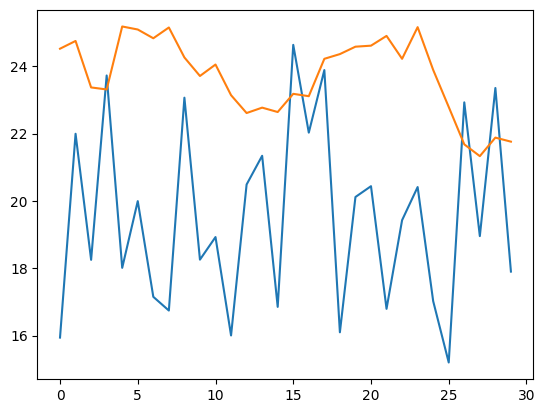

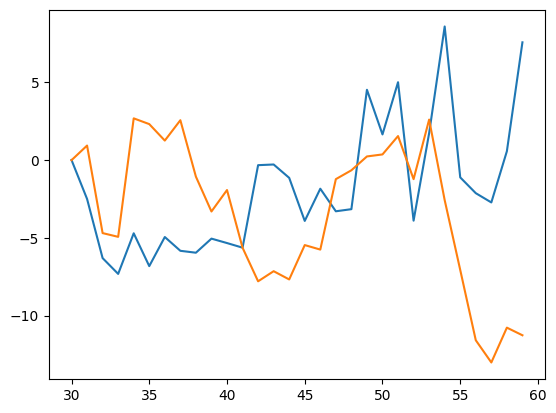

,y_predicted_price,y_actual_price
0,15.942512,24.52
1,21.994024,24.75
2,18.250874,23.37
3,23.724550,23.31
4,18.013704,25.18
5,19.994526,25.09
6,17.152815,24.83
7,16.745304,25.15
8,23.065567,24.26
9,18.256575,23.71


,y_predicted_percentage,y_actual_percentage
0,0.010470,0.00
1,-2.493580,0.94
2,-6.298055,-4.69
3,-7.313768,-4.93
4,-4.702001,2.69
5,-6.813630,2.32
6,-4.941381,1.26
7,-5.828454,2.57
8,-5.951242,-1.06
9,-5.045095,-3.30


In [27]:
test_predictions_unscaled = scaler_labels.inverse_transform(test_predictions)
y_test_unscaled = scaler_labels.inverse_transform(y_test)
for i in range(2):  
    plot_predictions(test_predictions_unscaled[i], y_test_unscaled[i], num_predictions)
    predictions_table(test_predictions_unscaled[i], y_test_unscaled[i], num_predictions)

## Save model on registry

In [28]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

In [30]:
model_dir = "solana_price_model_30d"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [33]:
mr = project.get_model_registry()


# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()


sample_indices = np.random.choice(X_test.shape[0], size=17, replace=False)
sample_test_values = X_test[sample_indices]

solana_model_1 = mr.python.create_model(
    name="solana_price_daily_model_30d", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=sample_test_values, 
    description="Solana daily price predictor. Predicts 30 days using solana lagged 10 timesteps, bitcoin lagged price (10) and fear greed index",
)

model_dir = "solana_price_model_30d/best_model.keras"

solana_model_1.save(model_dir)

Uploading: 100.000%|██████████| 52768/52768 elapsed<00:02 remaining<00:003,  1.25it/s]
Uploading: 100.000%|██████████| 24376/24376 elapsed<00:01 remaining<00:0007,  1.82s/it]
Uploading: 100.000%|██████████| 218/218 elapsed<00:02 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:13<00:00,  2.28s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1164448/models/solana_price_daily_model_30d/2


Model(name: 'solana_price_daily_model_30d', version: 2)

## Results

### Solana_price_daily_model_30d, v1:
    features: open_solana	open_bitcoin	fng_value	fng_classification
    Unormalized
    Mean Squared Error (MSE): 3052.8429657840406
    Root Mean Squared Error (RMSE): 55.25253809359386
    Normalized:
    Mean Squared Error (MSE): 0.04922278611417799
    Root Mean Squared Error (RMSE): 0.22186208805061308
    